<a href="https://colab.research.google.com/github/xander412/fmml2021/blob/main/Lab3_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data augmentation

FMML Module 1, Lab 3<br>
 Module Coordinator: Thrupthi Ann John thrupthi.ann@research.iiit.ac.in <br>
 Release date: 18 October 2021 <br>

 In this lab, we will see how augmentation of data samples help in improving the machine learning performance

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
# set randomseed
rng = np.random.default_rng(seed=42)
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
import math

Augmentation is useful when we have less training data available. Augmentation allows us to 'create' a larger dataset programatically. 

For this lab we will use a subset of MNIST that is very small, to better understand the effect of augmentation. 

In [18]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255

train_X = train_X[::1200,:,:].copy() # subsample. Otherwise it will take too long!
train_y = train_y[::1200].copy() # do the same to the labels


Let us borrow a few functions from the previous labs:

In [19]:
def NN1(traindata, trainlabel, query):
  diff  = traindata - query  # find the difference between features. Numpy automatically takes care of the size here 
  sq = diff*diff # square the differences
  dist = sq.sum(1) # add up the squares
  label = trainlabel[np.argmin(dist)] # our predicted label is the label of the training data which has the least distance from the query
  return label

def NN(traindata, trainlabel, testdata):
  # we will run nearest neighbour for each sample in the test data 
  # and collect the predicted classes in an array using list comprehension
  traindata = traindata.reshape(-1, 28*28)
  testdata = testdata.reshape(-1,28*28)
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum() # count the number of times the groundtruth label is equal to the predicted label.
  return correct/len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time.<br>

Let us check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [23]:
NN(train_X, train_y, test_X)

array([7, 2, 1, ..., 9, 9, 6], dtype=uint8)

In [24]:
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.6472


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits. 

### Augmentation 1: rotation

Let us try rotating the image a little. We will use skimage library for this. 

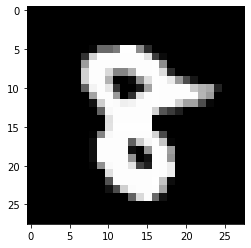

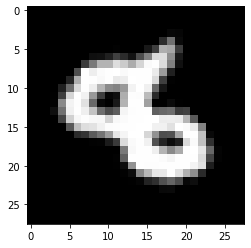

In [25]:
plt.imshow(train_X[2], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[2],45), cmap='gray')

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [26]:
def augRotate(sample, angleconstraint):
  if angleconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(sample[ii], angle[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

In [31]:
augRotate(train_X, 45)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple. 

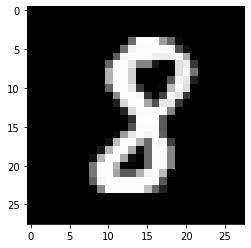

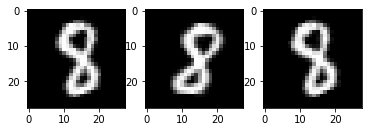

In [27]:
sample = train_X[20]
angleconstraint = 70
# show the original image
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show an augmented image
plt.subplot(1,3,2)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # one more image from the same sample

Let us augment the whole dataset and see if this improves the test accuracy

In [39]:
def augmentedTrain(angleconstraint, nagumentations):
    # hyperparameters
    augdata = train_X # we include the original images also in the augmented dataset
    auglabel = train_y
    for ii in range(naugmentations):
        augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint))) # concatenate the augmented data to the set
        auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augmen
    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    acc = Accuracy(test_y, testpred)
    print('Accuracy after rotation augmentation is ', acc)
    return acc

In [42]:
accuracyDict = {}
for x in range(50, 100):
    for y in range(1,10):
        accuracyDict[f'{x}, {y}'] = augmentedTrain(x, y)

Accuracy after rotation augmentation is  0.6712
Accuracy after rotation augmentation is  0.6776
Accuracy after rotation augmentation is  0.6728
Accuracy after rotation augmentation is  0.6764
Accuracy after rotation augmentation is  0.6627
Accuracy after rotation augmentation is  0.6622
Accuracy after rotation augmentation is  0.6686
Accuracy after rotation augmentation is  0.6742
Accuracy after rotation augmentation is  0.6734
Accuracy after rotation augmentation is  0.6759
Accuracy after rotation augmentation is  0.6675
Accuracy after rotation augmentation is  0.6804
Accuracy after rotation augmentation is  0.6731
Accuracy after rotation augmentation is  0.6723
Accuracy after rotation augmentation is  0.6619
Accuracy after rotation augmentation is  0.6732
Accuracy after rotation augmentation is  0.6746
Accuracy after rotation augmentation is  0.6724
Accuracy after rotation augmentation is  0.6722
Accuracy after rotation augmentation is  0.6699
Accuracy after rotation augmentation is 

0.6836

The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint.

In [44]:
angleconstraints = [0,10,20,30,40,50,60,70,80,90] # the values we want to test
accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here

for ii in range(len(angleconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after rotation augmentation constrained by  0  is  0.6472
Accuracy after rotation augmentation constrained by  10  is  0.6738
Accuracy after rotation augmentation constrained by  20  is  0.6843
Accuracy after rotation augmentation constrained by  30  is  0.6769
Accuracy after rotation augmentation constrained by  40  is  0.6817
Accuracy after rotation augmentation constrained by  50  is  0.6816
Accuracy after rotation augmentation constrained by  60  is  0.6631
Accuracy after rotation augmentation constrained by  70  is  0.6578
Accuracy after rotation augmentation constrained by  80  is  0.647
Accuracy after rotation augmentation constrained by  90  is  0.6371


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

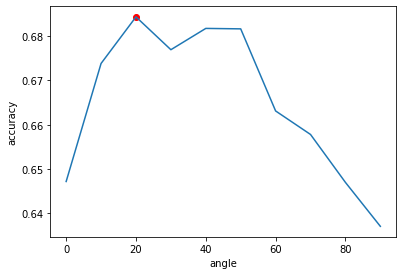

In [45]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

Let us try one more augmentation: shear. Here is what this looks like:

In [48]:
def shear(sample, amount):
  tform = AffineTransform(shear = amount) # create the shear transform
  img = warp(sample, tform) # apply the shear
  # this makes the digit off-center. Since all the images in the test set are centralized, we will do the same here
  col = img.sum(0).nonzero()[0]
  row = img.sum(1).nonzero()[0]
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
    yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
    img = np.roll(img, (xshift, yshift),(0,1))
  return img

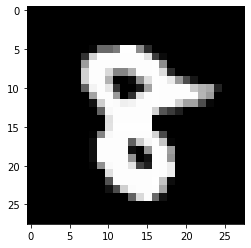

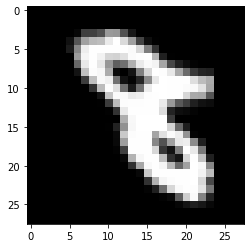

In [49]:
sample = train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()

# apply shear
plt.imshow(shear(sample, 0.4), cmap='gray')

Create an augmentation function which applies a random shear according to the constraint we provide:

In [56]:
def augShear(sample, shearconstraint):
  if shearconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

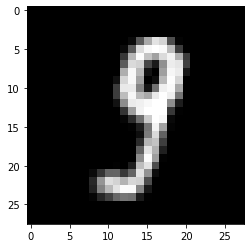

In [67]:
sheared = augShear(train_X, -1)
plt.imshow(sheared[6], cmap = 'gray')
plt.show()

In [68]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0] # the values we want to test
accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here

for ii in range(len(shearconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augShear(train_X, -shearconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after shear augmentation constrained by  0  is  0.6472
Accuracy after shear augmentation constrained by  0.2  is  0.6212
Accuracy after shear augmentation constrained by  0.4  is  0.6448
Accuracy after shear augmentation constrained by  0.6  is  0.6357
Accuracy after shear augmentation constrained by  0.8  is  0.6519
Accuracy after shear augmentation constrained by  1.0  is  0.6459
Accuracy after shear augmentation constrained by  1.2  is  0.6477
Accuracy after shear augmentation constrained by  1.4  is  0.6393
Accuracy after shear augmentation constrained by  1.6  is  0.5964
Accuracy after shear augmentation constrained by  1.8  is  0.604
Accuracy after shear augmentation constrained by  2.0  is  0.6085


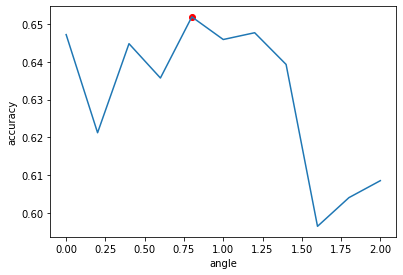

In [69]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')

We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters. 

In [53]:
def augRotateShear(sample, angleconstraint, shearconstraint):
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(shear(sample[ii], amt[ii]), angle[ii]) # first apply shear, then rotate
  return np.squeeze(nsample) # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters. 

In [54]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6] # the values we want to test
angleconstraints = [0,10,20,30,40,50,60] # the values we want to test
hyp = cartesian((shearconstraints, angleconstraints)) # cartesian product of both

accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here

for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

Accuracy after augmentation shear: 0.0 angle: 0.0  is  0.6332
Accuracy after augmentation shear: 0.0 angle: 10.0  is  0.6073
Accuracy after augmentation shear: 0.0 angle: 20.0  is  0.5922
Accuracy after augmentation shear: 0.0 angle: 30.0  is  0.6018
Accuracy after augmentation shear: 0.0 angle: 40.0  is  0.5771
Accuracy after augmentation shear: 0.0 angle: 50.0  is  0.6015
Accuracy after augmentation shear: 0.0 angle: 60.0  is  0.5712
Accuracy after augmentation shear: 0.2 angle: 0.0  is  0.6334
Accuracy after augmentation shear: 0.2 angle: 10.0  is  0.5772
Accuracy after augmentation shear: 0.2 angle: 20.0  is  0.6181
Accuracy after augmentation shear: 0.2 angle: 30.0  is  0.6023
Accuracy after augmentation shear: 0.2 angle: 40.0  is  0.6025
Accuracy after augmentation shear: 0.2 angle: 50.0  is  0.5873
Accuracy after augmentation shear: 0.2 angle: 60.0  is  0.6078
Accuracy after augmentation shear: 0.4 angle: 0.0  is  0.6335
Accuracy after augmentation shear: 0.4 angle: 10.0  is  0.

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

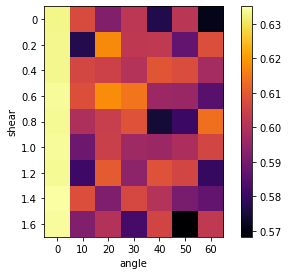

In [55]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
im = ax.imshow(accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap='inferno') 
ax.set_xlabel('angle')
ax.set_ylabel('shear')
ax.set_xticks(np.arange(len(angleconstraints)));
ax.set_xticklabels(angleconstraints);
ax.set_yticks(np.arange(len(shearconstraints)));
ax.set_yticklabels(shearconstraints);
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is 

when rotation is zero.

---



---



## Questions
Try these questions for better understanding. You may not be able tosolve all of them. 
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch. 

In [73]:
val = 0
optimalAngle = 0
print(accuracyDict)
for x in accuracyDict.keys():
    if accuracyDict[x] > val:
        val = accuracyDict[x]
        optimalAngle = x

{'50, 1': 0.6712, '50, 2': 0.6776, '50, 3': 0.6728, '50, 4': 0.6764, '50, 5': 0.6627, '50, 6': 0.6622, '50, 7': 0.6686, '50, 8': 0.6742, '50, 9': 0.6734, '51, 1': 0.6759, '51, 2': 0.6675, '51, 3': 0.6804, '51, 4': 0.6731, '51, 5': 0.6723, '51, 6': 0.6619, '51, 7': 0.6732, '51, 8': 0.6746, '51, 9': 0.6724, '52, 1': 0.6722, '52, 2': 0.6699, '52, 3': 0.6747, '52, 4': 0.6747, '52, 5': 0.6622, '52, 6': 0.6768, '52, 7': 0.6697, '52, 8': 0.6796, '52, 9': 0.6769, '53, 1': 0.6732, '53, 2': 0.6595, '53, 3': 0.6631, '53, 4': 0.6678, '53, 5': 0.6658, '53, 6': 0.6836, '53, 7': 0.663, '53, 8': 0.6582, '53, 9': 0.6703, '54, 1': 0.6793, '54, 2': 0.6694, '54, 3': 0.677, '54, 4': 0.6761, '54, 5': 0.6707, '54, 6': 0.6626, '54, 7': 0.6689, '54, 8': 0.6712, '54, 9': 0.6687, '55, 1': 0.6765, '55, 2': 0.6722, '55, 3': 0.664, '55, 4': 0.6735, '55, 5': 0.6728, '55, 6': 0.6707, '55, 7': 0.6622, '55, 8': 0.6758, '55, 9': 0.6745, '56, 1': 0.6617, '56, 2': 0.6542, '56, 3': 0.6784, '56, 4': 0.668, '56, 5': 0.6575, 

In [74]:
optimalAngle

'53, 6'

1. The best angle is at 53 with 6 number of augmentations with 68% accuracy. 
2. Best shear is at .75.
The accuracy is not increased much with respective to augmentations. The accuract still ranges between 60-70 no matter what the augmentations we tried so far.


In [75]:
augmentedTrain(50, 1), augmentedTrain(50, 23), augmentedTrain(50, 12)

Accuracy after rotation augmentation is  0.6684
Accuracy after rotation augmentation is  0.6797
Accuracy after rotation augmentation is  0.6814


(0.6684, 0.6797, 0.6814)

2. As you can see the number of augmentations is not effecting the accuracy that much atleast for this augmentation.

In [78]:
def augmentedTrain(angleconstraint, nagumentations):
    # hyperparameters
    augdata = train_X # we include the original images also in the augmented dataset
    auglabel = train_y
    for ii in range(naugmentations):
        augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint))) # concatenate the augmented data to the set
        auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augmen
        # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    acc = Accuracy(test_y, testpred)
    print('Accuracy after rotation augmentation is ',    acc)
    return testpred, test_y

In [90]:
pred = NN(train_X, train_y, test_X)


In [80]:
pred, y = augmentedTrain(20, 5)

Accuracy after rotation augmentation is  0.6714


In [91]:
#Test which are the most wrongly predicted numbers..........
count = {}
for x,z in zip(pred,test_y):
    if x != z:
        try:
            count[z] += 1
        except:
            count[z] = 1

In [92]:
count

{0: 315, 1: 25, 2: 502, 3: 320, 4: 341, 5: 703, 6: 229, 7: 324, 8: 472, 9: 297}

In [105]:
train_X.shape

(50, 28, 28)

In [138]:
def augmentedTrain(angleconstraint, nagumentations):
    # hyperparameters
    augdata = train_X # we include the original images also in the augmented dataset
    dat = train_X[train_y == 2].copy()
    for x in range(5):
        dat = np.concatenate((dat, augRotate(dat, rng.random(1)*10)))
    print(dat.shape, augdata.shape)
    auglabel = train_y.copy()
    dat = np.concatenate((augdata, dat))
    auglabel = np.concatenate((auglabel, np.array([2] * len(dat))))
    testpred = NN(dat, auglabel, test_X)
    acc = Accuracy(test_y, testpred)
    print('Accuracy after rotation augmentation is ',    acc)
    return testpred, test_y

In [139]:
augmentedTrain(10,1)

(128, 28, 28) (50, 28, 28)
Accuracy after rotation augmentation is  0.6545


(array([7, 2, 1, ..., 9, 9, 6]), array([7, 2, 1, ..., 4, 5, 6], dtype=uint8))

I tried finding the numbers which are causing most of the errors. But even if the appropriate augmentations are made the accuracy is still between 60-70 percent.

In [178]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255

train_X = train_X[::2500,:,:].copy() # subsample. Otherwise it will take too long!
train_y = train_y[::2500].copy() # do the same to the labels


In [179]:
train_X.shape

(24, 28, 28)

In [180]:
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.5304


4. We must require atleast 24 length data set to achieve 50 percent accuracy.